# Prices Simulation from Stooq API

We will see a simple example of how to simulated stock prices from some historical stocks prices dowload from the web.

## Download historical data

First we will download some historical stock prices from symbols (ticker), over date range, start to end. For this purpose we use the a library called ``pandas_datareader`` that allows us to download stocks prices from various API. Here we use the [Stooq](https://stooq.com/) finance datas.   

The historical stock prices are stored in the ``df_prices`` variable as a ``pd.DataFrame``.

In [35]:
from datetime import datetime
import pandas_datareader.data as web

stocks = ["ge", "intc", "amd", "gold", "spy", "ko", "pep"]
start, end = datetime(2017, 1, 1), datetime(2020, 1, 1)
df = web.DataReader(stocks, "stooq", start=start, end=end)
df_prices = df["Close"]

## Make a prevision on the anual expected return

We define expected annual returns as a dictionary that we called ``era`` and a number of simulated prices ``spn`` to be predicted for each previously downloaded stock. We intentionally chose an unreal expected return like -0.8 for the *ge* ticker and -0.99 for the *spy* Ticker to stress the simulation.

In [36]:
ear = {
    "ge": -0.8,
    "intc": 10,
    "amd": -0.1,
    "gold": -0.5,
    "spy": -0.99,
    "ko": 0.08,
    "pep": 0.01,
}
spn = 254

## Simulate future prices

1. Check that ``df_prices`` contains prices using the ``Stocks`` object.


In [37]:
from portfolioqtopt.simulation.stocks import Stocks
from portfolioqtopt.simulation.simulation import Simulation

stocks_history = Stocks(df=df_prices)

2. Create the ``simulation`` instance of the ``Simulation`` class.

In [38]:
simulation = Simulation(stocks_history, er=ear, m=spn)

3. Make the simulation with the given historical stock prices, the anual expected returns and the numbers of days. The results is a ``tuple`` containing future returns, covariance and prices respectively names ``future_returns``, ``future_cov``, ``future_prices``.

In [39]:
future_returns, future_cov, future_prices = simulation(order=12)

2023-01-18 15:42:54.785 | WARNING  | portfolioqtopt.simulation.simulation:correlate:74 - Correlated daily returns not all inf to 1!
2023-01-18 15:42:56.346 | INFO     | portfolioqtopt.simulation.simulation:get_returns_adjustment:133 - dl=Polynomial([   1.37339256,  254.29729026, -127.35862566,   85.08676002,
        -63.98173518,   51.3435935 ,  -42.93901651,   36.953864  ,
        -32.4739782 ,   29.00896408,  -25.57484917,   23.09090909], domain=[-1.,  1.], window=[-1.,  1.], symbol='x'), r_min=-0.05640796347509452, r_max=0.0605728739300041
2023-01-18 15:42:56.348 | INFO     | portfolioqtopt.simulation.simulation:get_returns_adjustment:133 - dl=Polynomial([  -2.60155086,  254.24019179, -127.27676698,   84.9800635 ,
        -63.85009706,   51.18688349,  -42.75709898,   36.74648277,
        -32.24533927,   28.75441528,  -25.56714276,   23.09090909], domain=[-1.,  1.], window=[-1.,  1.], symbol='x'), r_min=-0.05003434659978559, r_max=0.045098096369829165
2023-01-18 15:42:56.349 | INFO  

4. Plot the historical prices follow by the simulated ones on the same plot.

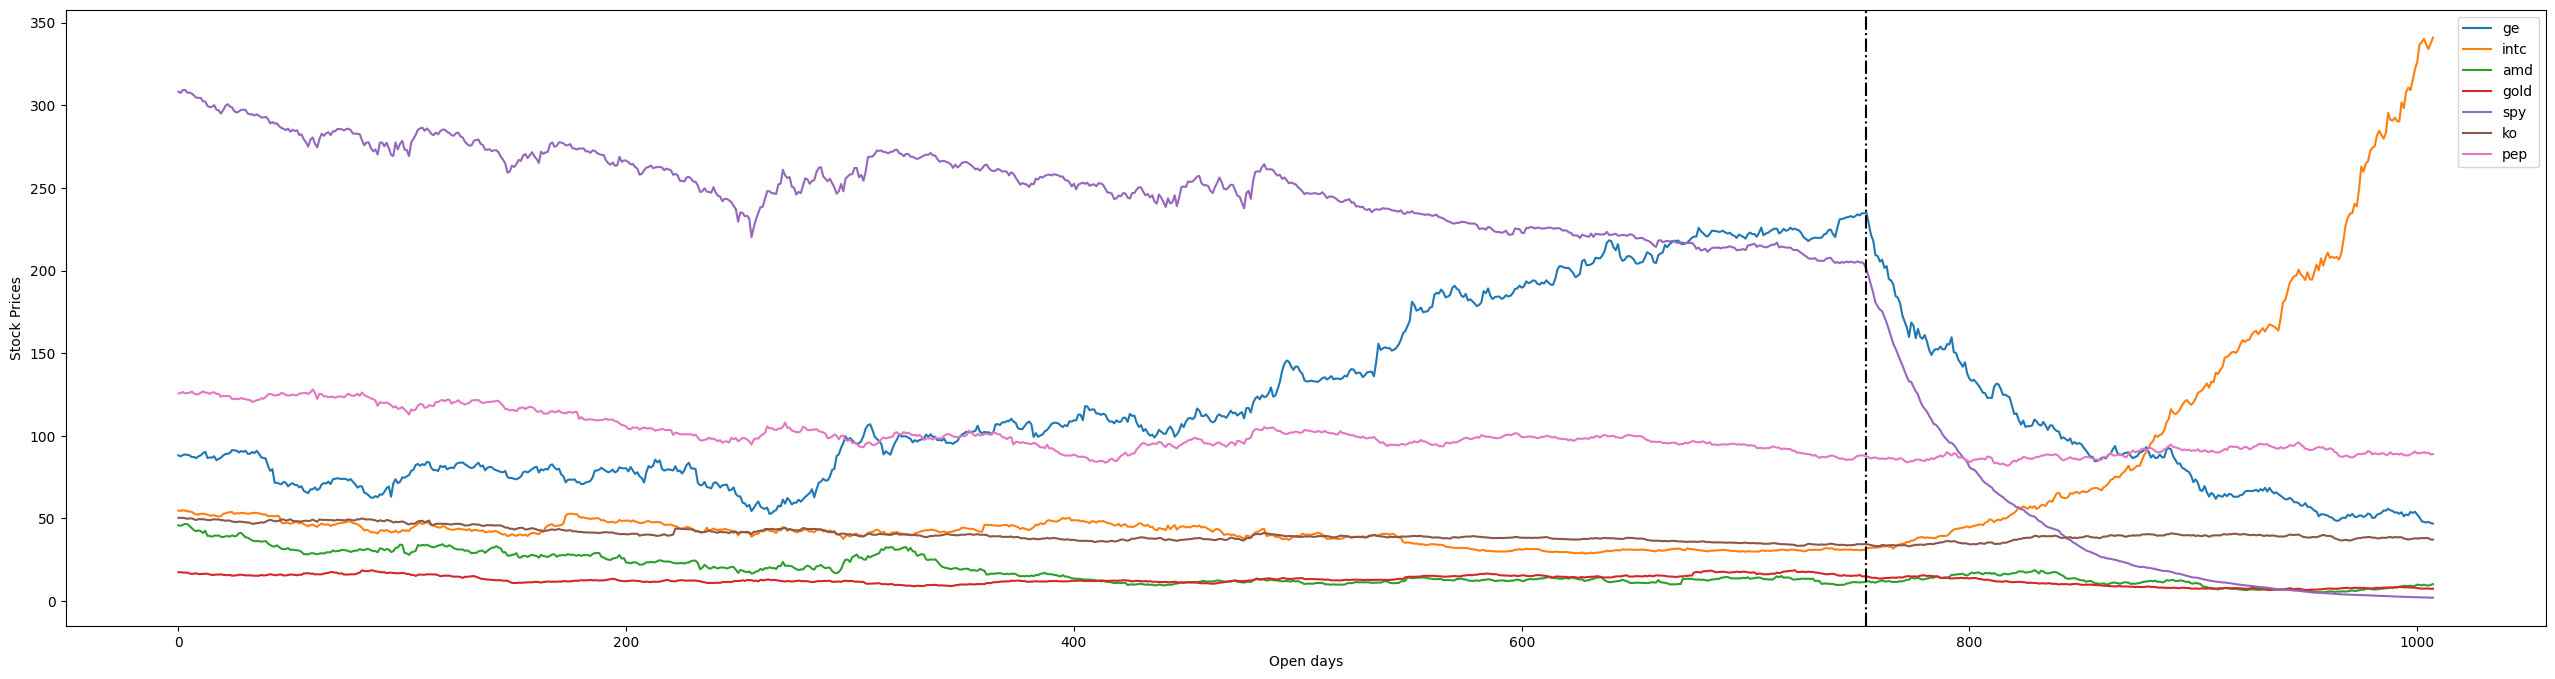

In [40]:
import numpy as np
import matplotlib.pyplot as plt

n = stocks_history.df.to_numpy().shape[0]  # Number of days in the history.
m = future_prices.shape[1]  # Number of predicted days

# legend
stocks_names = stocks_history.df.columns
k = len(stocks_names)  # Number of stocks

prices = np.vstack(
    (stocks_history.prices.T, future_prices[:, 1:].T)
)  # shape (n + m, k)

fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(prices, label=stocks_names)
ax.axvline(x=n, ymin=0, ymax=1, c="black", linestyle="-.")
ax.set_xlabel("Open days")
ax.set_ylabel("Stock Prices")
ax.legend();

## Verify the quality of the results

To be sure that all is as expected we verify that:

1. The covariance of the daily returns of our simulated prices are the same as the historical one.  
   We call ``sar`` the simulated anual returns and ``dar`` the desired anual returns and made an assertion to verify that they are very close to each other.

In [41]:
sar = future_prices.T[-1, :] / future_prices.T[0, :] - 1
dar = np.array(list(ear.values()))  # desired anual returns
assert np.allclose(sar, dar)

2. The anual returns of the each simulated stock are the same as the given ones.  
   For that we can write a simple function call ``get_daily_returns()`` to compute the daily returns given an array of prices.

In [42]:
import numpy.typing as npt

def get_daily_returns(array: npt.NDArray) -> npt.NDArray:
    # array: shape (n, k)
    # output: shape (n-1, k)
    return np.diff(array, axis=1) / array[:, :-1]

Finally we verify that the obtained covariance is identical to the one compute with the simulated prices.

1. Compute the daily return.  
2. Compute the covariance ``future_cov`` and ``history_cov``.   
3. Verify that they are very close to each other.   

In [43]:
future_returns = get_daily_returns(future_prices)
future_cov = np.cov(future_returns)

history_returns = get_daily_returns(stocks_history.prices)
history_cov = np.cov(history_returns)

assert np.allclose(history_cov, future_cov)

All work as expected!

In [44]:
import pandas as pd

simulated_prices = pd.DataFrame(future_prices.T, columns=ear).to_json()  # A sting...